## ``Retail Sales Forecasting``

In [1]:
# Lets import in libraries

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import datetime as dt
from datetime import datetime

import xlsxwriter

from sklearn.model_selection import train_test_split
from sklearn import linear_model, ensemble, neighbors, metrics, tree

print("Imported Successfuly")

Imported Successfuly


In [2]:
pd.set_option('display.max_row', 400)
pd.set_option('display.max_columns', 400)

### ``train.csv``

In [3]:
# Now lets load the train and test csv files
# train.csv
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_8ce100d855324b029c264b5adbe35a6b = 'https://s3.eu.cloud-object-storage.appdomain.cloud'
else:
    endpoint_8ce100d855324b029c264b5adbe35a6b = 'https://s3.private.eu.cloud-object-storage.appdomain.cloud'

client_8ce100d855324b029c264b5adbe35a6b = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='mcDfWmCSMfx_YSdsV8c65SyVmPtDhbFz9eKciyAtejPk',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_8ce100d855324b029c264b5adbe35a6b)

body = client_8ce100d855324b029c264b5adbe35a6b.get_object(Bucket='walmartsalesforecasting-donotdelete-pr-gjlpflkneokbg3',Key='train.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
# df_data_1.head()
train = df_data_1    # ranaming to train
train.head(4)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False


### ``test.csv``

In [4]:
# test data
body = client_8ce100d855324b029c264b5adbe35a6b.get_object(Bucket='walmartsalesforecasting-donotdelete-pr-gjlpflkneokbg3',Key='test.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)
# df_data_2.head()
test = df_data_2
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


### ``feature.csv``

In [5]:
# Now lets import additional files
# feature.csv
body = client_8ce100d855324b029c264b5adbe35a6b.get_object(Bucket='walmartsalesforecasting-donotdelete-pr-gjlpflkneokbg3',Key='features.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_3 = pd.read_csv(body)
# df_data_3.head()
feature = df_data_3
feature.head(3)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False


### ``store.csv``

In [6]:
# store.csv
body = client_8ce100d855324b029c264b5adbe35a6b.get_object(Bucket='walmartsalesforecasting-donotdelete-pr-gjlpflkneokbg3',Key='stores.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_4 = pd.read_csv(body)
# df_data_4.head()
store = df_data_4
store.head(3)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392


In [7]:
print("Dimenstion of train:{}\nDimenstion of test:{}".format(train.shape, test.shape))

Dimenstion of train:(421570, 5)
Dimenstion of test:(115064, 4)


In [8]:
# as we can see some features from the store as well as feature dataframe might be useful for out hypothesis
# so, we will merge them all together, for that we can use pd.merge()
train = pd.merge(train, feature)
train = pd.merge(train, store)

# same for test 
test = pd.merge(test, feature)
test = pd.merge(test, store)

In [9]:
print("Dimenstion of train:{}\nDimenstion of test:{}".format(train.shape, test.shape))

Dimenstion of train:(421570, 16)
Dimenstion of test:(115064, 15)


## ``Exploratory Data Analysis``

In [10]:
train.info()
print("----------#-------------#----------------")
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB
----------#-------------

In [11]:
train.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


In [12]:
test.describe()

,Store,Dept,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,115064.000000,115064.000000,115064.000000,115064.000000,114915.000000,86437.000000,105235.000000,102176.000000,115064.000000,76902.000000,76902.000000,115064.000000
mean,22.238207,44.339524,53.941804,3.581546,7689.216439,3734.051729,2403.088666,3356.219071,3922.681189,176.961347,6.868733,136497.688921
std,12.809930,30.656410,18.724153,0.239442,10698.760716,8323.495014,13767.939313,7570.501545,19445.150745,41.239967,1.583427,61106.926438
min,1.000000,1.000000,-7.290000,2.872000,-2781.450000,-35.740000,-179.260000,0.220000,-185.170000,131.236226,3.684000,34875.000000
25%,11.000000,18.000000,39.820000,3.431000,1966.460000,180.350000,15.100000,155.460000,1309.300000,138.402033,5.771000,93638.000000
50%,22.000000,37.000000,54.470000,3.606000,4842.290000,742.590000,78.260000,840.940000,2390.430000,192.304445,6.806000,140167.000000
75%,33.000000,74.000000,67.350000,3.766000,9439.140000,2735.670000,272.580000,3096.920000,4227.270000,223.244532,8.036000,202505.000000
max,45.000000,99.000000,101.950000,4.125000,103184.980000,71074.170000,149483.310000,65344.640000,771448.100000,228.976456,10.199000,219622.000000


In [13]:
train.describe(include = ['object'])

,Date,Type
count,421570,421570
unique,143,3
top,2011-12-23,A
freq,3027,215478


In [14]:
test.describe(include = ['object'])

,Date,Type
count,115064,115064
unique,39,3
top,2012-12-21,A
freq,3002,58713


In [15]:
# lets check for correlation between these features.
train_corr = train.corr()
train_corr.head(40)

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
Store,1.000000,0.024004,-0.085195,-0.000548,-0.050097,0.065290,-0.119588,-0.035173,-0.031556,-0.009941,-0.026634,-0.211088,0.208552,-0.182881
Dept,0.024004,1.000000,0.148032,0.000916,0.004437,0.003572,-0.002426,0.000290,0.001784,0.004257,0.000109,-0.007477,0.007837,-0.002966
Weekly_Sales,-0.085195,0.148032,1.000000,0.012774,-0.002312,-0.000120,0.085251,0.024130,0.060385,0.045414,0.090362,-0.020921,-0.025864,0.243828
IsHoliday,-0.000548,0.000916,0.012774,1.000000,-0.155949,-0.078281,-0.035586,0.334818,0.427960,-0.000562,-0.053719,-0.001944,0.010460,0.000593
Temperature,-0.050097,0.004437,-0.002312,-0.155949,1.000000,0.143859,-0.040594,-0.323927,-0.096880,-0.063947,-0.017544,0.182112,0.096730,-0.058313
Fuel_Price,0.065290,0.003572,-0.000120,-0.078281,0.143859,1.000000,0.061371,-0.220895,-0.102092,-0.044986,-0.128065,-0.164210,-0.033853,0.003361
MarkDown1,-0.119588,-0.002426,0.085251,-0.035586,-0.040594,0.061371,1.000000,0.024486,-0.108115,0.819238,0.160257,-0.055558,0.050285,0.345673
MarkDown2,-0.035173,0.000290,0.024130,0.334818,-0.323927,-0.220895,0.024486,1.000000,-0.050108,-0.007768,-0.007440,-0.039534,0.020940,0.108827
MarkDown3,-0.031556,0.001784,0.060385,0.427960,-0.096880,-0.102092,-0.108115,-0.050108,1.000000,-0.071095,-0.026467,-0.023590,0.012818,0.048913
MarkDown4,-0.009941,0.004257,0.045414,-0.000562,-0.063947,-0.044986,0.819238,-0.007768,-0.071095,1.000000,0.107792,-0.049628,0.024963,0.168196


In [16]:
test_corr = test.corr()
test_corr.head(40)

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
Store,1.000000,0.019627,-0.001166,-0.043495,0.153425,-0.091707,-0.041370,-0.025177,0.010331,0.010419,-0.214872,0.250321,-0.186845
Dept,0.019627,1.000000,0.001249,0.003970,0.000554,-0.002353,0.001292,0.000247,0.002510,0.000776,-0.006336,0.004087,0.001502
IsHoliday,-0.001166,0.001249,1.000000,-0.187428,-0.126443,0.355257,0.265402,0.496062,0.289700,-0.019386,-0.001475,0.010288,-0.000443
Temperature,-0.043495,0.003970,-0.187428,1.000000,0.073938,-0.168899,-0.324280,-0.049771,-0.059583,0.003937,0.280861,0.022136,-0.061256
Fuel_Price,0.153425,0.000554,-0.126443,0.073938,1.000000,0.083320,-0.161963,-0.005827,0.034199,0.012722,-0.465721,0.417126,0.055088
MarkDown1,-0.091707,-0.002353,0.355257,-0.168899,0.083320,1.000000,0.001777,-0.090085,0.804449,0.061714,-0.028729,0.019241,0.309614
MarkDown2,-0.041370,0.001292,0.265402,-0.324280,-0.161963,0.001777,1.000000,-0.063757,-0.101784,-0.014159,-0.059350,-0.000547,0.157526
MarkDown3,-0.025177,0.000247,0.496062,-0.049771,-0.005827,-0.090085,-0.063757,1.000000,-0.059576,-0.015305,-0.022021,0.006298,0.050088
MarkDown4,0.010331,0.002510,0.289700,-0.059583,0.034199,0.804449,-0.101784,-0.059576,1.000000,0.024163,-0.056629,0.021993,0.155448
MarkDown5,0.010419,0.000776,-0.019386,0.003937,0.012722,0.061714,-0.014159,-0.015305,0.024163,1.000000,-0.025105,0.063864,0.103681


In [17]:
print(train.shape)
train.head(3)

(421570, 16)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [18]:
# similarly we can use seaborn's heatmap to study correlation

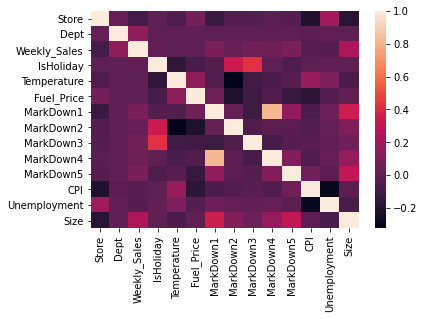

In [19]:
sns.heatmap(train_corr)
plt.show()

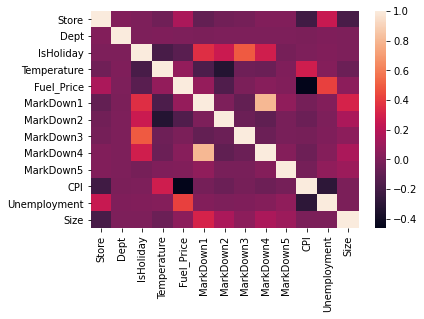

In [20]:
sns.heatmap(test_corr)
plt.show()

#### ``Sales vs Size``

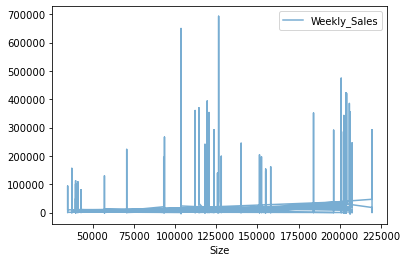

In [21]:
# from the correlation dataframes and heatmap we can see that features such as 'size', 'dept' have comparatively larger 
# correlation value with feature 'weekly_sales'

train.plot(kind='line', x='Size', y='Weekly_Sales', figsize=(6,4), alpha=0.6)
plt.show()

#### ``Sales Vs Dept``

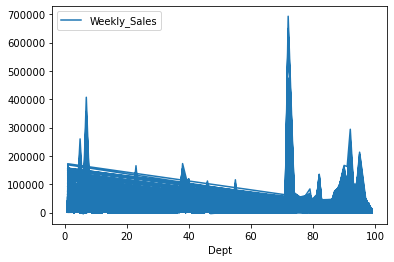

In [22]:
train.plot(kind='line', x='Dept', y='Weekly_Sales', figsize=(6,4))
plt.show()

#### ``Sales vs Type``

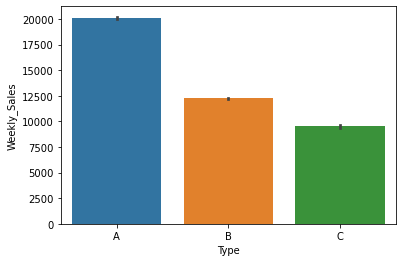

In [23]:
sns.barplot(x=train['Type'], y=train['Weekly_Sales'])
plt.show()

### ``Data Wrangling``

In [24]:
train.info()
print("----#----------#-------#-----------#--------")
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 68.0+ MB
----#----------#-------#

In [25]:
print(train.isnull().sum())
print("-----#----------#------------#----------#----")
print(test.isnull().sum())

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64
-----#----------#------------#----------#----
Store               0
Dept                0
Date                0
IsHoliday           0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
Type                0
Size                0
dtype: int64


In [26]:
# we need to change the null values of CPI and Unemployment in test 
median_CPI_value = test['CPI'].astype('float').median(axis=0)
print("Median Value of CPI column: {}".format(median_CPI_value))

median_unemployment_value = test['Unemployment'].astype('float').median(axis=0)
print("Median Value of Unemployment column: {}".format(median_unemployment_value))

Median Value of CPI column: 192.3044449
Median Value of Unemployment column: 6.806


In [27]:
test['CPI'].replace(np.nan, median_CPI_value, inplace=True)
test['Unemployment'].replace(np.nan, median_unemployment_value, inplace=True)

In [28]:
test.isnull().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI                 0
Unemployment        0
Type                0
Size                0
dtype: int64

In [29]:
train = train.fillna(0)
test = test.fillna(0)

### ``Feature Extraction``

In [30]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315


In [31]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [32]:
train.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
dtype: object

In [33]:
# Now extract date features from given dates

train['day_oftheweek'] = train['Date'].dt.dayofweek
train['Date_month'] = train['Date'].dt.month
train['Date_year'] = train['Date'].dt.year
train['Date_day'] = train['Date'].dt.day

test['day_oftheweek'] = test['Date'].dt.dayofweek
test['Date_month'] = test['Date'].dt.month
test['Date_year'] = test['Date'].dt.year
test['Date_day'] = test['Date'].dt.day

In [34]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,day_oftheweek,Date_month,Date_year,Date_day
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,4,2,2010,5
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,4,2,2010,5
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,4,2,2010,5
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,4,2,2010,5
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,4,2,2010,5


In [35]:
train_test_data = [train, test]

In [36]:
train.Type.nunique()

3

In [37]:
type_mapping = {'A':1, 'B':2, 'C':3}
for dataset in train_test_data:
    dataset['Type'] = dataset['Type'].map(type_mapping)

In [38]:
type_mapping = {False: 0, True: 1}
for dataset in train_test_data:
    dataset['IsHoliday'] = dataset['IsHoliday'].map(type_mapping)

In [39]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,day_oftheweek,Date_month,Date_year,Date_day
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,4,2,2010,5
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,4,2,2010,5
2,1,3,2010-02-05,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,4,2,2010,5
3,1,4,2010-02-05,39954.04,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,4,2,2010,5
4,1,5,2010-02-05,32229.38,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,4,2,2010,5


In [40]:
train['Super_Bowl'] = np.where((train['Date']==datetime(2010, 2, 12)) | (train['Date']==datetime(2011, 2, 11)) | (train['Date']==datetime(2012, 2, 10)) | (train['Date']==datetime(2013, 2, 8)),1,0)
train['Labour_Day'] = np.where((train['Date']==datetime(2010, 5, 1)) | (train['Date']==datetime(2011, 9, 9)) | (train['Date']==datetime(2012, 9, 7)) | (train['Date']==datetime(2013, 9, 6)),1,0)
train['Thanksgiving'] = np.where((train['Date']==datetime(2010, 11, 26)) | (train['Date']==datetime(2011, 11, 25)) | (train['Date']==datetime(2012, 11, 23)) | (train['Date']==datetime(2013, 11, 29)),1,0)
train['Christmas'] = np.where((train['Date']==datetime(2010, 12, 31)) | (train['Date']==datetime(2011, 12, 30)) | (train['Date']==datetime(2012, 12, 28)) | (train['Date']==datetime(2013, 12, 27)),1,0)
#........................................................................
test['Super_Bowl'] = np.where((test['Date']==datetime(2010, 2, 12)) | (test['Date']==datetime(2011, 2, 11)) | (test['Date']==datetime(2012, 2, 10)) | (test['Date']==datetime(2013, 2, 8)),1,0)
test['Labour_Day'] = np.where((test['Date']==datetime(2010, 9, 10)) | (test['Date']==datetime(2011, 9, 9)) | (test['Date']==datetime(2012, 9, 7)) | (test['Date']==datetime(2013, 9, 6)),1,0)
test['Thanksgiving'] = np.where((test['Date']==datetime(2010, 11, 26)) | (test['Date']==datetime(2011, 11, 25)) | (test['Date']==datetime(2012, 11, 23)) | (test['Date']==datetime(2013, 11, 29)),1,0)
test['Christmas'] = np.where((test['Date']==datetime(2010, 12, 31)) | (test['Date']==datetime(2011, 12, 30)) | (test['Date']==datetime(2012, 12, 28)) | (test['Date']==datetime(2013, 12, 27)),1,0)

In [41]:
train['IsHoliday'] = train['IsHoliday']|train['Super_Bowl']|train['Labour_Day']|train['Thanksgiving']|train['Christmas']
test['IsHoliday'] = test['IsHoliday']|test['Super_Bowl']|test['Labour_Day']|test['Thanksgiving']|test['Christmas']

In [42]:
# Since we have Imputed IsHoliday according to Extra holidays..These extra holiday variable has redundant..
# Droping the Extra holiday variables because its redundant..
dp=['Super_Bowl','Labour_Day','Thanksgiving','Christmas']
train.drop(dp,axis=1,inplace=True)
test.drop(dp,axis=1,inplace=True)

In [43]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,day_oftheweek,Date_month,Date_year,Date_day
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,4,2,2010,5
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,4,2,2010,5
2,1,3,2010-02-05,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,4,2,2010,5
3,1,4,2010-02-05,39954.04,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,4,2,2010,5
4,1,5,2010-02-05,32229.38,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,4,2,2010,5


### ``Feature Selection``

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Store          421570 non-null  int64         
 1   Dept           421570 non-null  int64         
 2   Date           421570 non-null  datetime64[ns]
 3   Weekly_Sales   421570 non-null  float64       
 4   IsHoliday      421570 non-null  int64         
 5   Temperature    421570 non-null  float64       
 6   Fuel_Price     421570 non-null  float64       
 7   MarkDown1      421570 non-null  float64       
 8   MarkDown2      421570 non-null  float64       
 9   MarkDown3      421570 non-null  float64       
 10  MarkDown4      421570 non-null  float64       
 11  MarkDown5      421570 non-null  float64       
 12  CPI            421570 non-null  float64       
 13  Unemployment   421570 non-null  float64       
 14  Type           421570 non-null  int64         
 15  

In [45]:
# dropping markdown_5, CPI and unemployment
lst = ['Unemployment','CPI','MarkDown5']
train = train.drop(lst, axis = 1)
test = test.drop(lst, axis = 1)

In [46]:
print("Dimenstions of train: {}\nDimenstions of test: {}".format(train.shape, test.shape))

Dimenstions of train: (421570, 17)
Dimenstions of test: (115064, 16)


In [47]:
train.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Type,Size,day_oftheweek,Date_month,Date_year,Date_day
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,1,151315,4,2,2010,5
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,1,151315,4,2,2010,5
2,1,3,2010-02-05,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,1,151315,4,2,2010,5


In [48]:
test.head(3)

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Type,Size,day_oftheweek,Date_month,Date_year,Date_day
0,1,1,2012-11-02,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,1,151315,4,11,2012,2
1,1,2,2012-11-02,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,1,151315,4,11,2012,2
2,1,3,2012-11-02,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,1,151315,4,11,2012,2


### ``Defining train and test for testing``

In [49]:
train_x = train.drop(['Weekly_Sales','Date'], axis = 1)
train_y = train['Weekly_Sales']

test_x = test.drop(['Date'], axis = 1)

train_x.shape, train_y.shape, test_x.shape

((421570, 15), (421570,), (115064, 15))

#### ``Regression``

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

``Linear Regression``

In [51]:
clf = LinearRegression()
clf.fit(train_x, train_y)
y_pred_linear=clf.predict(test_x)
acc_linear=round( clf.score(train_x, train_y) * 100, 2)
print ('score:'+str(acc_linear) + ' percent')

score:8.65 percent


``Decision Tree``

In [52]:
clf=DecisionTreeRegressor()
clf.fit(train_x, train_y)
y_pred_dt= clf.predict(test_x)
acc_dt = round( clf.score(train_x, train_y) * 100, 2)
print (str(acc_dt) + ' percent')

100.0 percent


In [53]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree'],
    
    'Score': [acc_linear, acc_dt]
    })

models.sort_values(by='Score', ascending=False)

,Model,Score
1,Decision Tree,100.00
0,Linear Regression,8.65


## ``Decision Tree work awesome here``